# Import libs

In [2]:
import pandas as pd
import numpy as np
import scipy
from utils.functions import min_max_normalization, plot_column_histogram_and_distribution, confusion_matrix, create_samples_rejection_method
from sklearn.model_selection import train_test_split
from models.naive_bayes_classifier.naive_bayes_classifier import naive_bayes_classifier

# Import Column dataset and doing normalization

In [3]:
columns_name = [
    'pelvic_incidence', 
    'pelvic_tilt', 
    'lumbar_lordosis_angle', 
    'sacral_slope', 
    'pelvic_radius', 
    'degree_spondylolisthesis',
    'class'
]
Xy = pd.read_csv('./datasets/vertebral_column_3C.dat', header=0, names=columns_name, sep=' ', engine='python')

X = min_max_normalization(Xy.drop(Xy.columns[-1:], axis=1))
y = Xy[Xy.columns[-1]]

# Plotting the column distributions

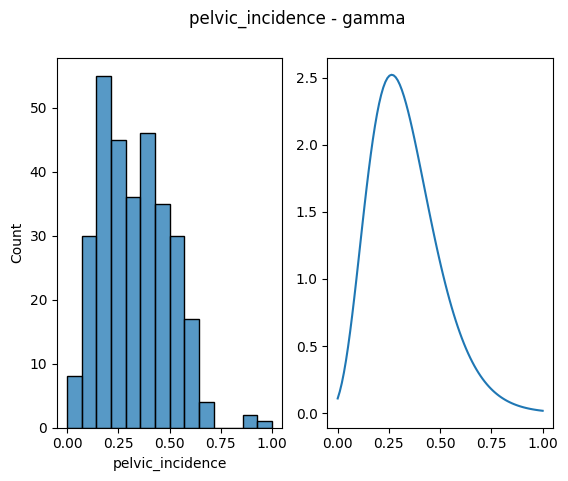

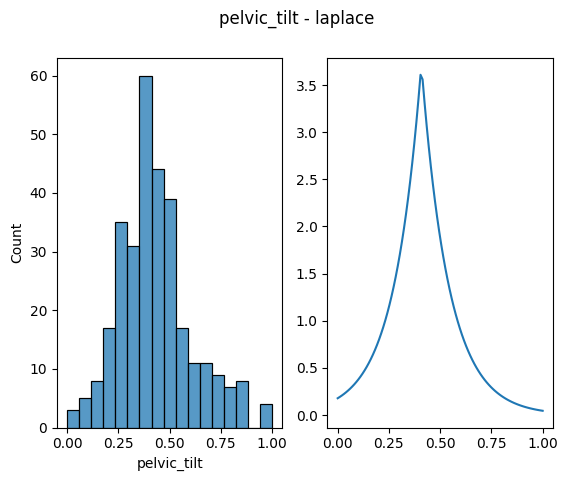

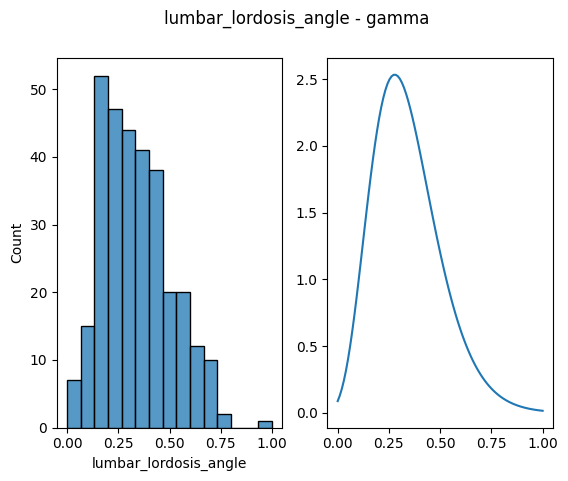

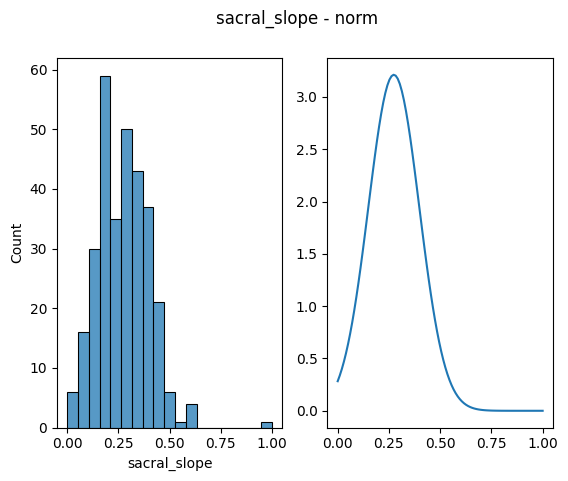

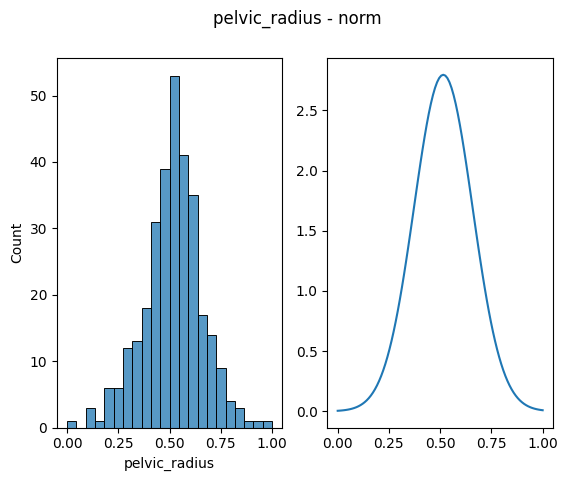

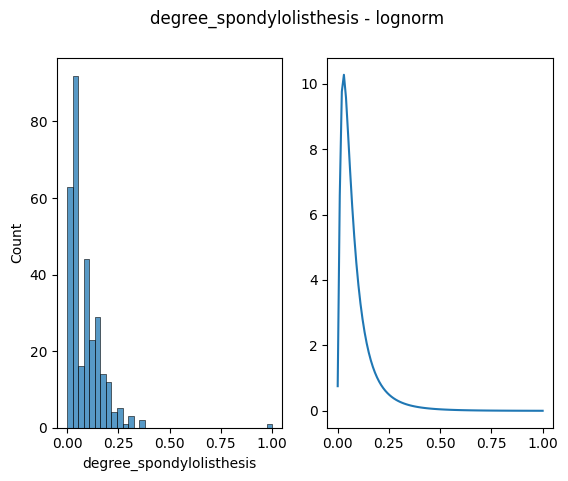

In [4]:
distributions = ['gamma', 'laplace', 'gamma', 'norm', 'norm', 'lognorm']

for feature_name, distribution in zip(X.columns, distributions):
    plot_column_histogram_and_distribution(X[feature_name], feature_name, distribution)

# New Naive Bayes implementation

In [5]:
class naive_bayes_classifier:
    def __init__(self, features_distribution=[]):
        # will save the priori for each class
        self.__priori = []  # [<priori_class_1>, <priori_class_2>, ...]

        # will save the distribution type for each column
        self.__features_distribution = features_distribution

        #                                                                                   attrb 1      attrb 2
        # will save the distribuition instance of each attribute for each class: class 1 [(mean, std), (mean, std), ...]
        #                                                                        class 2 [    ...    ,     ...    , ...]
        self.__features_distribution_instances = pd.DataFrame([[]])

    def fit(self, X, y):
        if len(self.__features_distribution) == 0:
            self.__features_distribution = ['norm' for _ in range(len(X.columns))]
        elif len(self.__features_distribution) != len(X.columns):
            raise Exception('Features distributions size is different X columns size')

        classes = pd.Series(y.unique())
        values = [[() for _ in range(len(X.columns))] for _ in range(len(classes))]
        self.__features_distribution_instances = pd.DataFrame(values, columns=X.columns, index=classes)

        for cls in self.__features_distribution_instances.index.values:
            i_cls_samples = X.index[np.where(y == cls)] # this take the index returned for np and take the pd (X) index
            Xc = X.loc[i_cls_samples]
            self.__priori.append(len(Xc) / len(X))  # insert priori for each group of samples separated per class

            for feature, feat_distribution in zip(X.columns, self.__features_distribution):
                distribution = getattr(scipy.stats, feat_distribution)
                distr_params = distribution.fit(Xc[feature])
                self.__features_distribution_instances.loc[cls, feature] = distr_params
    
    def predict(self, x):
        if len(x) != len(self.__features_distribution_instances.columns):
            raise Exception('Sample invalid')

        posteriors = [] # [[<posteriori>, <class>], ...]

        for i_cls, cls in enumerate(self.__features_distribution_instances.index.values):
            likelihood = 1
            for i_feature, feature in enumerate(self.__features_distribution_instances.columns):
                distribution = getattr(scipy.stats, self.__features_distribution[i_feature])
                distr_params = self.__features_distribution_instances.loc[cls, feature]
                new_distribution = distribution(*distr_params)
                likelihood = likelihood * new_distribution.pdf(x[i_feature])

            posteriors.append([
                likelihood * self.__priori[i_cls], 
                cls
            ])

        greater_posteriori_class = sorted(
            posteriors,
            key=lambda posteriors: posteriors[0] # sorted by posteriori
        )[-1][1]

        return greater_posteriori_class

    def score(self, X_test, y_test):
        hits = 0

        for sample, predict in zip(X_test.values, y_test.values):
            if self.predict(sample) == predict:
                hits += 1

        return hits/y_test.size

# Training and testing the new Naiva Bayes model with the Column dataset

In [6]:
realizations = 20
nb_hit_rate_list = []
nb_std_dev = 0
nb_confusion_matrix_list = []

for r in range(realizations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    nb_model = naive_bayes_classifier(distributions)
    nb_model.fit(X_train, y_train)

    nb_hit_rate_list.append(nb_model.score(X_test, y_test))

    nb_y_pred = [nb_model.predict(x) for x in X_test.values]

    nb_confusion_matrix_list.append(confusion_matrix(y_test, nb_y_pred))

nb_std_dev = np.std(nb_hit_rate_list)

print('----------------- NAIVE BAYES model -----------------')
print('Hit rate:')
print(nb_hit_rate_list, end='\n\n')

print('Accuracy:')
print(sum(nb_hit_rate_list)/len(nb_hit_rate_list), end='\n\n')

print('Standard Deviation:')
print(nb_std_dev, end='\n\n')

print('Confusion Matrix:')
for matrix in nb_confusion_matrix_list:
    print(matrix, end='\n')

----------------- NAIVE BAYES model -----------------
Hit rate:
[0.8709677419354839, 0.8870967741935484, 0.8387096774193549, 0.8387096774193549, 0.8064516129032258, 0.7741935483870968, 0.8548387096774194, 0.8548387096774194, 0.8387096774193549, 0.8225806451612904, 0.7903225806451613, 0.8225806451612904, 0.8709677419354839, 0.8064516129032258, 0.9032258064516129, 0.8709677419354839, 0.8064516129032258, 0.8548387096774194, 0.8064516129032258, 0.7580645161290323]

Accuracy:
0.8338709677419356

Standard Deviation:
0.03716683426388037

Confusion Matrix:
    NO  SL  DH
NO  13   1   5
SL   1  30   0
DH   1   0  11
    NO  DH  SL
NO  21   2   0
DH   4   3   0
SL   1   0  31
    SL  DH  NO
SL  26   0   3
DH   0  11   4
NO   1   2  15
    NO  DH  SL
NO  18   5   1
DH   2  10   1
SL   1   0  24
    SL  NO  DH
SL  28   1   0
NO   2  15   5
DH   0   4   7
    DH  NO  SL
DH   8   3   1
NO   6  14   4
SL   0   0  26
    SL  DH  NO
SL  32   0   1
DH   1   6   1
NO   1   5  15
    NO  SL  DH
NO  14   3

# Adding samples in Column dataset 

In [7]:
print(f'Qtd samples: {X.index.size}')
for cls in y.unique():    
    print(f'Qtd {cls}: {len(X.index[np.where(y == cls)])}')

Qtd samples: 309
Qtd DH: 59
Qtd SL: 150
Qtd NO: 100


In [8]:
new_X, new_y = create_samples_rejection_method(X, y, {'SL': 150, 'DH': 241, 'NO': 200})

print(f'Qtd samples: {new_X.index.size}')
for cls in new_y.unique():    
    print(f'Qtd {cls}: {len(new_X.index[np.where(new_y == cls)])}')

Qtd samples: 900
Qtd DH: 300
Qtd SL: 300
Qtd NO: 300


# Plotting the new column distributions

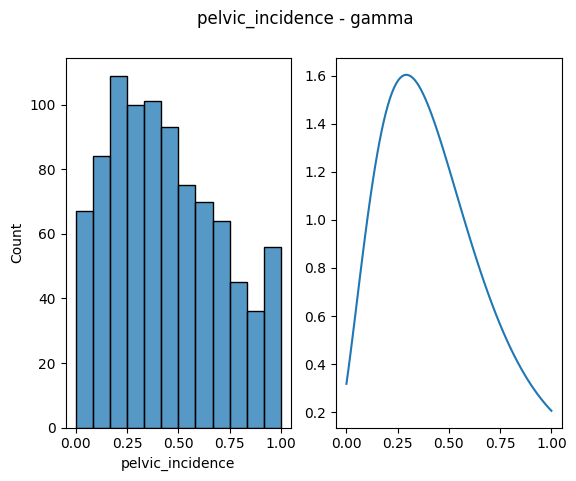

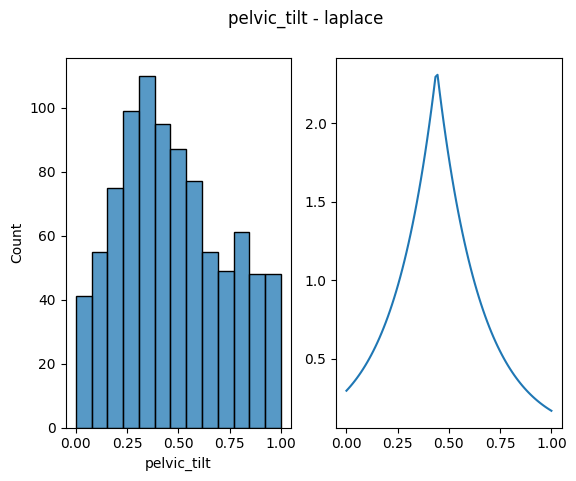

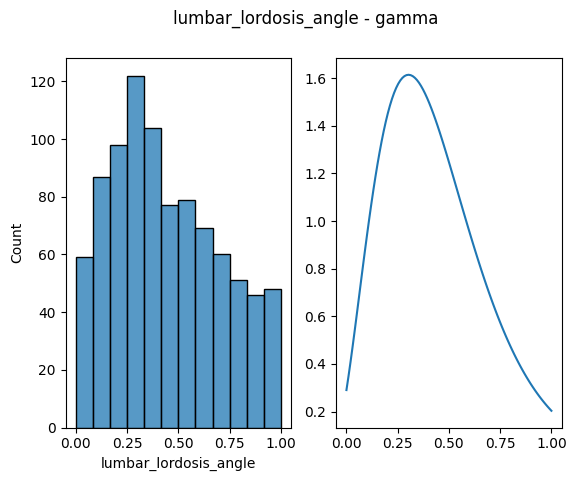

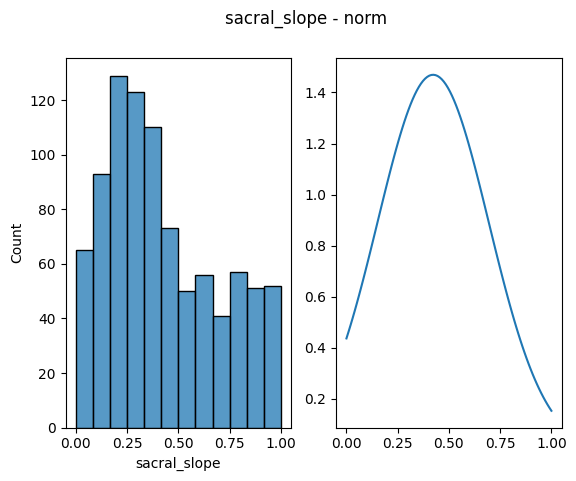

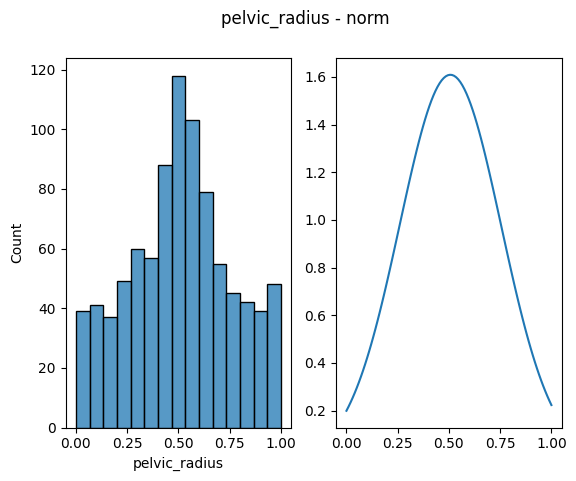

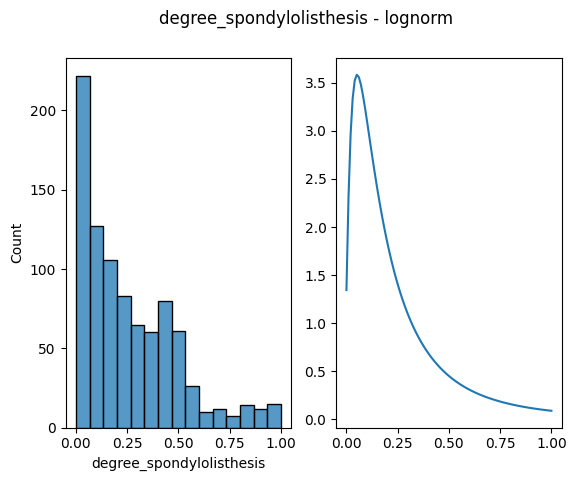

In [9]:
for feature_name, distribution in zip(new_X.columns, distributions):
    plot_column_histogram_and_distribution(new_X[feature_name], feature_name, distribution)

# Doing the same with the Iris dataset

In [11]:
Xy = pd.read_csv('./datasets/iris.csv')
X = min_max_normalization(Xy.drop(['class'], axis=1))
y = Xy['class']

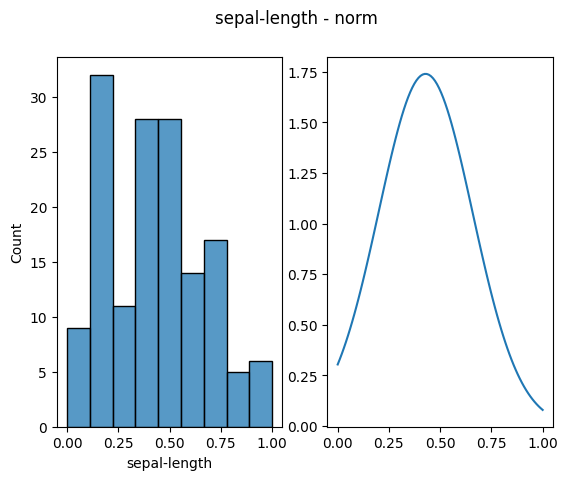

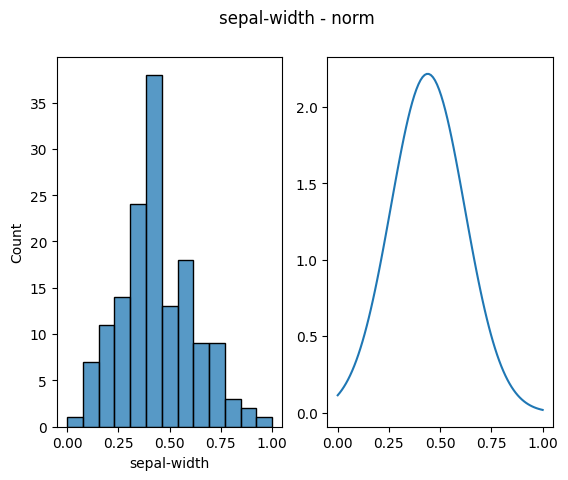

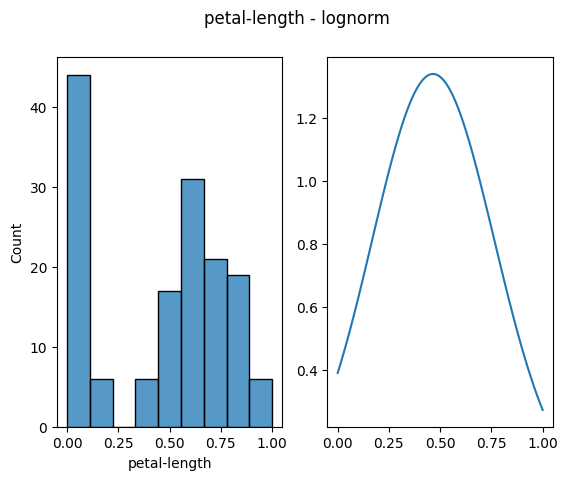

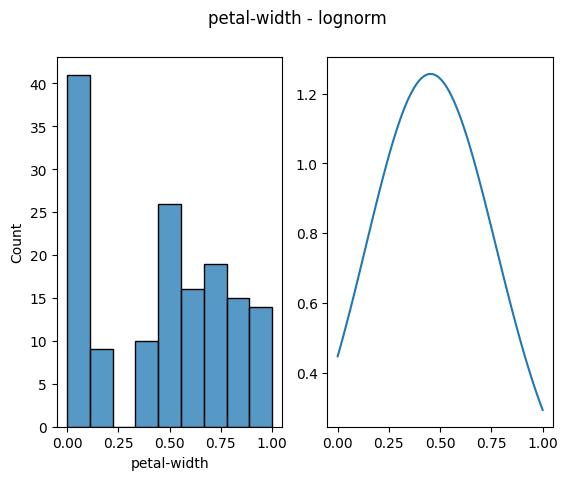

In [12]:
distributions = ['norm', 'norm', 'lognorm', 'lognorm']

for feature_name, distribution in zip(X.columns, distributions):
    plot_column_histogram_and_distribution(X[feature_name], feature_name, distribution)

In [13]:
realizations = 20
nb_hit_rate_list = []
nb_std_dev = 0
nb_confusion_matrix_list = []

for r in range(realizations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    nb_model = naive_bayes_classifier(distributions)
    nb_model.fit(X_train, y_train)

    nb_hit_rate_list.append(nb_model.score(X_test, y_test))

    nb_y_pred = [nb_model.predict(x) for x in X_test.values]

    nb_confusion_matrix_list.append(confusion_matrix(y_test, nb_y_pred))

nb_std_dev = np.std(nb_hit_rate_list)

print('----------------- NAIVE BAYES model -----------------')
print('Hit rate:')
print(nb_hit_rate_list, end='\n\n')

print('Accuracy:')
print(sum(nb_hit_rate_list)/len(nb_hit_rate_list), end='\n\n')

print('Standard Deviation:')
print(nb_std_dev, end='\n\n')

print('Confusion Matrix:')
for matrix in nb_confusion_matrix_list:
    print(matrix, end='\n')

----------------- NAIVE BAYES model -----------------
Hit rate:
[0.9666666666666667, 1.0, 0.9333333333333333, 0.9666666666666667, 0.9333333333333333, 0.9666666666666667, 0.9, 0.8666666666666667, 1.0, 0.9666666666666667, 0.9666666666666667, 0.9, 0.9333333333333333, 0.9666666666666667, 0.9333333333333333, 1.0, 0.9333333333333333, 0.9333333333333333, 1.0, 0.9666666666666667]

Accuracy:
0.9516666666666668

Standard Deviation:
0.03570714214271425

Confusion Matrix:
                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               13                0               0
Iris-versicolor            0               10               1
Iris-virginica             0                0               6
                 Iris-versicolor  Iris-virginica  Iris-setosa
Iris-versicolor               11               0            0
Iris-virginica                 0              12            0
Iris-setosa                    0               0            7
                 Iris-setosa  Iris-virg

In [14]:
print(f'Qtd samples: {X.index.size}')
for cls in y.unique():    
    print(f'Qtd {cls}: {len(X.index[np.where(y == cls)])}')

Qtd samples: 150
Qtd Iris-setosa: 50
Qtd Iris-versicolor: 50
Qtd Iris-virginica: 50


In [15]:
new_X, new_y = create_samples_rejection_method(X, y, {'Iris-setosa': 250, 'Iris-versicolor': 250, 'Iris-virginica': 250})

print(f'Qtd samples: {new_X.index.size}')
for cls in new_y.unique():    
    print(f'Qtd {cls}: {len(new_X.index[np.where(new_y == cls)])}')

Qtd samples: 900
Qtd Iris-setosa: 300
Qtd Iris-versicolor: 300
Qtd Iris-virginica: 300


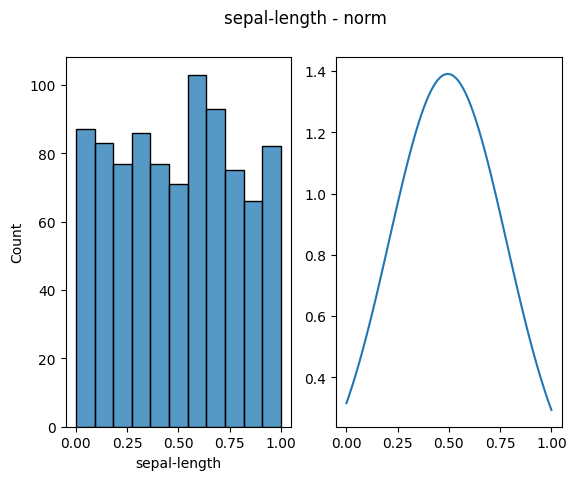

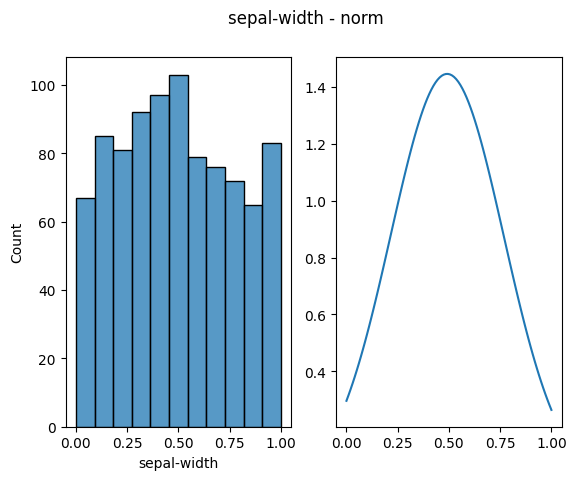

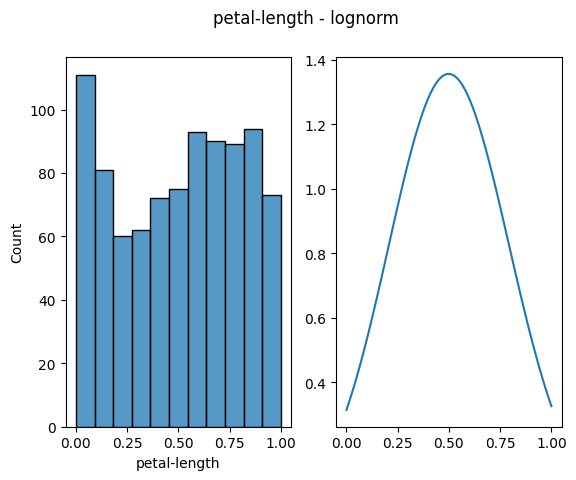

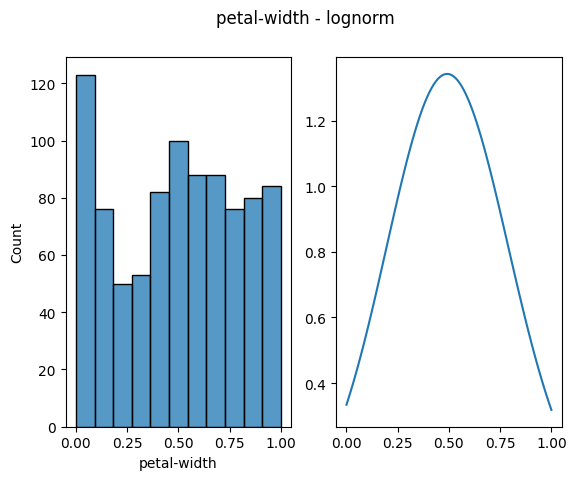

In [16]:
for feature_name, distribution in zip(new_X.columns, distributions):
    plot_column_histogram_and_distribution(new_X[feature_name], feature_name, distribution)